<a href="https://colab.research.google.com/github/davetew/Modern-Aerospace-Propulsion/blob/dev/Week%206%20-%20Turbomachinery/Gas_Turbine_T4_Performance_Sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gas Turbine Turbine Inlet Temperature (T4) Performance Sensitivity
The objective of this notebook is to evaluate the sensitivity of the efficiency and specific power to the turbine inlet temperature.

A simple ideal and calorically perfect gas turbine model will be used for the performance evaluation.


In [ ]:
#@title Importing the required colab-standard Python modules
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, titleweight="bold")     # font size & weight of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, titleweight="bold")    # font size & weight of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, titleweight="bold")

import seaborn as sns
import pandas as pd
import datetime

from scipy.optimize import brentq, minimize, Bounds

In [ ]:
!pip install https://github.com/davetew/Zero-Carbon-Aviation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 185 kB 2.8 MB/s
  ERROR: Cannot unpack file /tmp/pip-unpack-8814eyl_/Zero-Carbon-Aviation (downloaded from /tmp/pip-req-build-qiz4pzds, content-type: text/html; charset=utf-8); cannot detect archive format
ERROR: Cannot determine archive format of /tmp/pip-req-build-qiz4pzds


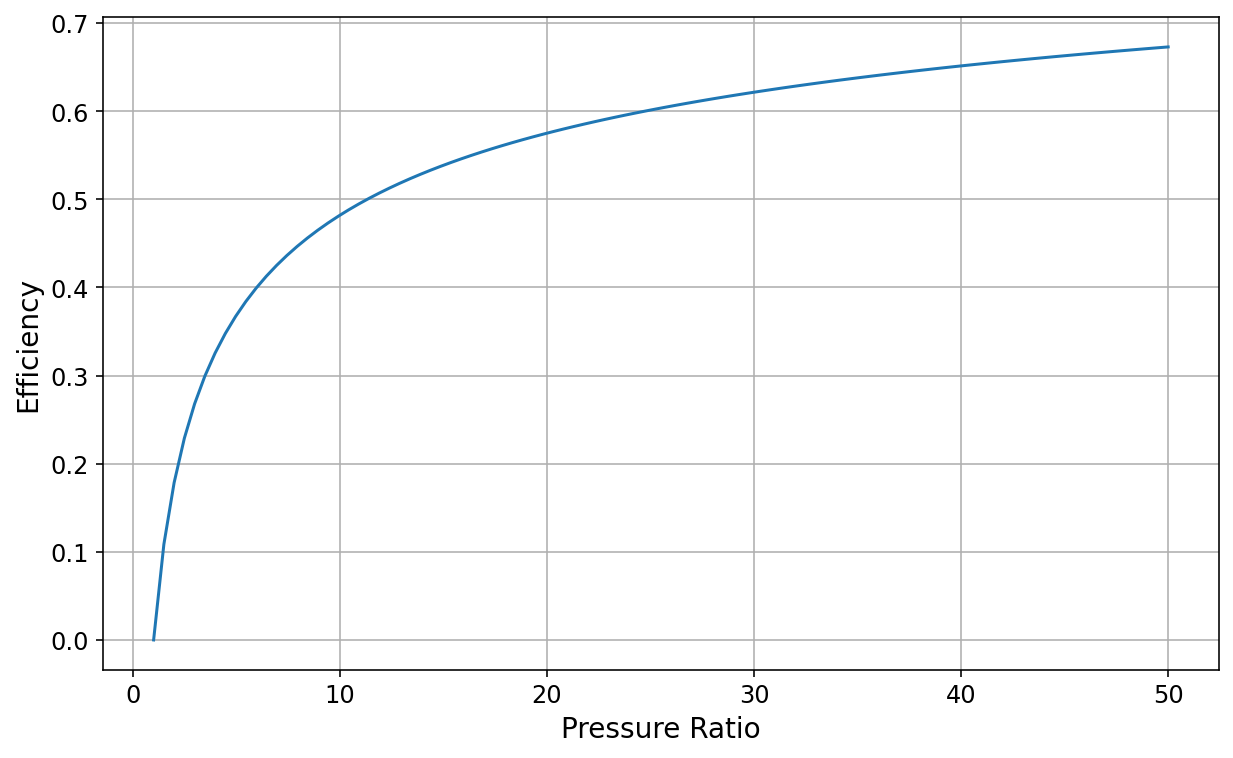

In [ ]:
"""Ideal Brayton cycle efficiency vs pressure ratio"""
PR = np.linspace(1,50,100)

# Ideal Brayton cycle efficiency
η_ideal_brayton = lambda pr, γ=1.4: 1 - 1/pr**((γ-1)/γ)

# Plot the thermal efficiency vs PR
plt.figure(figsize=(10,6))
plt.plot(PR, [η_ideal_brayton(pr) for pr in PR])
plt.xlabel('Pressure Ratio')
plt.ylabel('Efficiency')
plt.grid(); plt.show()


In [ ]:
class SimpleBraytonCycle:

  # Ambient conditions

  def __init__(self, PR=None, Turbine_Inlet_Temperature_C=1500,
              ηpoly_compressor=1.0, ηpoly_turbine=1.0,
              T_ambient_C=25, p_ambient_kPa=100,
              R_J_kgK = 287.058, γ=1.4,
              target_mass_specific_work_kJ_kg=None,
              Turbine_Metal_Temperature_C=1200,
              StantonNumber=0.07,
              burnerPR=0.98, coolingPR=0.95):

    self.T_combustor_exit = Turbine_Inlet_Temperature_C + 273.15
    self.ηpoly = {"compressor": ηpoly_compressor,
                  "turbine": ηpoly_turbine}
    self.burnerPR = burnerPR
    self.coolingPR = coolingPR

    if Turbine_Metal_Temperature_C is None:
      self.Turbine_Metal_Temperature = self.T_combustor_exit
    else:
      self.Turbine_Metal_Temperature = Turbine_Metal_Temperature_C + 273.15

    self.StantonNumber=StantonNumber

    self.ambient = {'T_K': T_ambient_C + 273.15,
                    'p_Pa': p_ambient_kPa * 1000,
                    'γ': γ,
                    'R_J_kgK': 287,
                    'cp_J_kgK': R_J_kgK * γ / (γ-1)}
    if PR is None:
      # Calculate the PR that yields the target mass specific work
      if target_mass_specific_work_kJ_kg is None:
        raise ValueError('Either PR or target_mass_specific_work must be specified.')
      self.PR = self.calcPR(target_mass_specific_work_kJ_kg)
    else:
      self.PR = PR

  def calcPR(self, target_work_kJ_kg):

    def δwork(pr):
      return ( SimpleBraytonCycle(PR=pr,
                                  Turbine_Inlet_Temperature_C=self.T_combustor_exit - 273.15,
                                  ηpoly_compressor= self.ηpoly["compressor"],
                                  ηpoly_turbine=self.ηpoly["turbine"],
                                  T_ambient_C=self.ambient["T_K"] - 273.15,
                                  p_ambient_kPa=self.ambient["p_Pa"]/1000,
                                  R_J_kgK = self.ambient["R_J_kgK"],
                                  γ=self.ambient["γ"],
                                  target_mass_specific_work_kJ_kg=None,
                                  Turbine_Metal_Temperature_C=self.Turbine_Metal_Temperature - 273.15,
                                  StantonNumber=self.StantonNumber,
                                  burnerPR=self.burnerPR,
                                  coolingPR=self.coolingPR,
                                  ).mass_specific_work/1000 -
                target_work_kJ_kg )

    # Calculate the PR that results in the target mass specific work
    try:
      pr, results = brentq(δwork, 1, 40, full_output=True)
    except ValueError:
      return np.nan

    # Return an answer if the solver converges
    return pr if results.converged else np.nan

  def optimize(self):
    """Optimize the cycle for maximum efficiency subject to the component efficiency and material
    temperature limits provided"""

    def inefficiency(x):
      """Calculate and return the 'inefficiency' or 1 - efficiency"""
      return 1 - SimpleBraytonCycle(PR=x[0],
                                    Turbine_Inlet_Temperature_C=x[1],
                                    ηpoly_compressor= self.ηpoly["compressor"],
                                    ηpoly_turbine=self.ηpoly["turbine"],
                                    T_ambient_C=self.ambient["T_K"] - 273.15,
                                    p_ambient_kPa=self.ambient["p_Pa"]/1000,
                                    R_J_kgK = self.ambient["R_J_kgK"],
                                    γ=self.ambient["γ"],
                                    target_mass_specific_work_kJ_kg=None,
                                    Turbine_Metal_Temperature_C=self.Turbine_Metal_Temperature - 273.15,
                                    StantonNumber=self.StantonNumber,
                                    burnerPR=self.burnerPR,
                                    coolingPR=self.coolingPR,
                                    ).efficiency

    try:
      results = minimize(inefficiency, [self.PR, self.T_combustor_exit], method='trust-constr',
                         bounds=Bounds([1, 1273], [60, 2273]))

    except ValueError:
      return None

    else:
      if results.status == 1 or results.status == 2:
        self.PR = results.x[0]
        self.T_combustor_exit = results.x[1]
        return self
      else:
        return None

  @property
  def T_compressor_exit(self):
    return self.ambient["T_K"]*self.PR**((self.ambient["γ"]-1)/self.ambient["γ"]/self.ηpoly["compressor"])

  @property
  def βcooling(self):
    """Turbine cooling / inlet mass flow ratio"""
    return ( self.StantonNumber*(self.T_combustor_exit-self.Turbine_Metal_Temperature) /
            (self.Turbine_Metal_Temperature - self.T_compressor_exit) )

  @property
  def turbinePR(self):
    """Turbine inlet to exhaust pressure ratio"""
    return self.PR*(self.burnerPR*(1-self.βcooling) + self.coolingPR*self.βcooling)

  @property
  def T_turbine_inlet(self):
    """Temperature after mixing of combustor exit and cooling flows"""
    return self.T_compressor_exit*self.βcooling + self.T_combustor_exit*(1-self.βcooling)

  @property
  def T_turbine_exit(self):
    return self.T_turbine_inlet*self.turbinePR**(-(self.ambient["γ"]-1)*self.ηpoly["turbine"]/self.ambient["γ"])

  @property
  def mass_specific_heat_addition(self):
    return (self.T_combustor_exit - self.T_compressor_exit)*self.ambient["cp_J_kgK"]*(1-self.βcooling)

  @property
  def mass_specific_work(self):
    return ( self.T_turbine_inlet - self.T_turbine_exit -
            (self.T_compressor_exit - self.ambient["T_K"]) )*self.ambient["cp_J_kgK"]

  @property
  def efficiency(self):
    return self.mass_specific_work / self.mass_specific_heat_addition

  @property
  def cycleTemperatures(self):
    return np.array([self.ambient["T_K"], self.T_compressor_exit,
                    self.T_combustor_exit, self.T_turbine_inlet,
                    self.T_turbine_exit] )

  @property
  def cyclePressures(self):
    return self.ambient["p_Pa"]* np.array([1, self.PR, self.PR*self.burnerPR,
                                           self.turbinePR, 1])

  @property
  def cycleEnthalpies(self):
    return np.array([self.enthalpy(T) for T in self.cycleTemperatures])

  @property
  def cycleEntropies(self):
    return np.array( [self.entropy(T, p) for T, p in
                      zip(self.cycleTemperatures, self.cyclePressures)] )

  def enthalpy(self, T):
    """Calcuate and return the mass-specific enthalpy given the temperature in K"""
    return self.ambient["cp_J_kgK"]*(T - self.ambient["T_K"])

  def entropy(self, T, p):
    """Calcuate and return the mass-specific entropy given the temperature in K
    and pressure in Pa"""
    return ( self.ambient["cp_J_kgK"]*np.log(T/self.ambient["T_K"]) -
            self.ambient["R_J_kgK"]*np.log(p/self.ambient["p_Pa"]) )

  def cycleDiagrams(self):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

    # Temperature-Entropy Diagram
    ax1.plot(self.cycleEntropies, self.cycleTemperatures, marker='d')
    ax1.set_xlabel('Entropy (J/kg/K)')
    ax1.set_ylabel('Temperature ($^{\circ}$C)')
    ax1.grid()
    ax1.set_title(f'TS: Efficiency= {self.efficiency*100:0.0f}%')

    # Pressure-Enthalpy
    ax2.plot(self.cycleEnthalpies/1000, self.cyclePressures/1000, marker='p')
    ax2.set_xlabel('Enthalpy (kJ/kg)')
    ax2.set_ylabel('Pressure (kPa)')
    ax2.grid()
    ax2.set_title(f'PH: Specific Work={self.mass_specific_work/1000:.0f} kJ/kg')

39.159207189855614

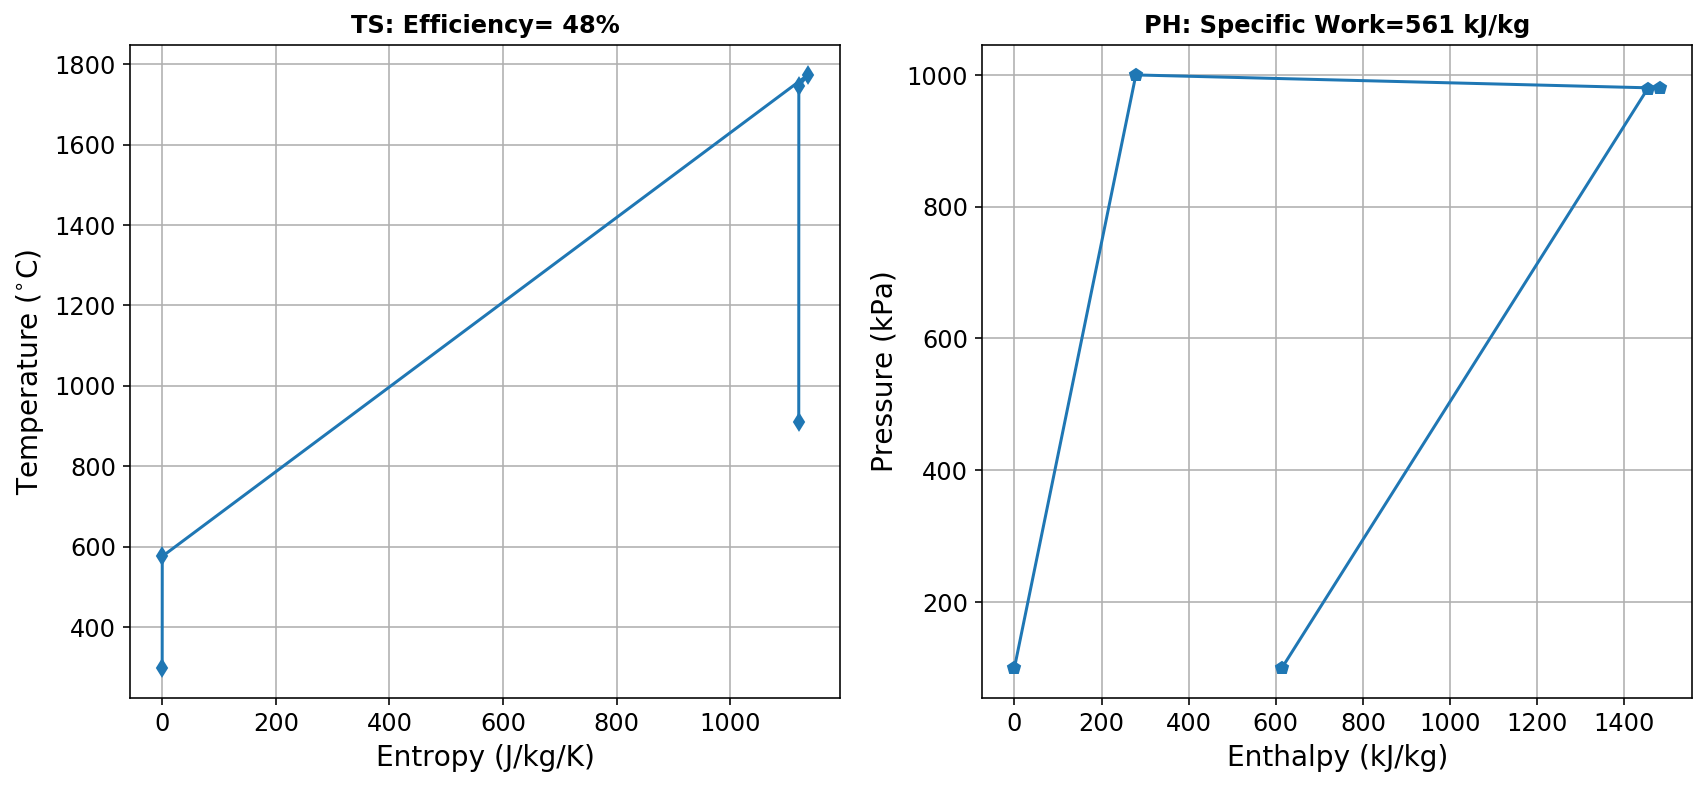

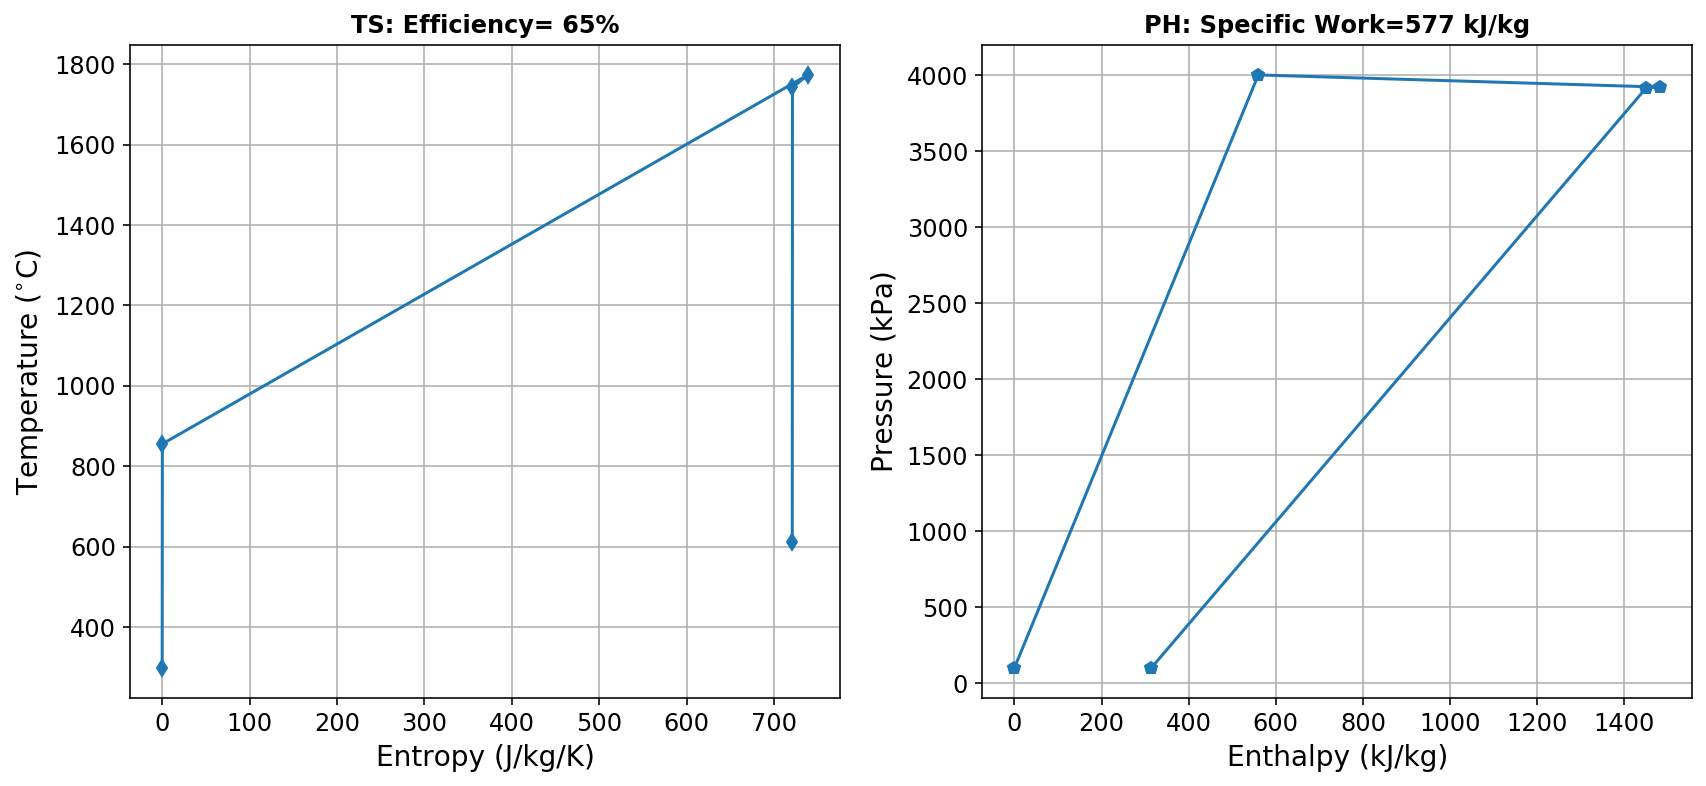

In [ ]:
"""Simple Brayton Cycle Model"""

# Design parameters
SimpleBraytonCycle(PR=10).cycleDiagrams()
SimpleBraytonCycle(PR=40).cycleDiagrams()
SimpleBraytonCycle(PR=40).βcooling
SimpleBraytonCycle(PR=40).turbinePR

Text(0, 0.5, 'Bottom Cycle Work / Topping Fuel Enthalpy')

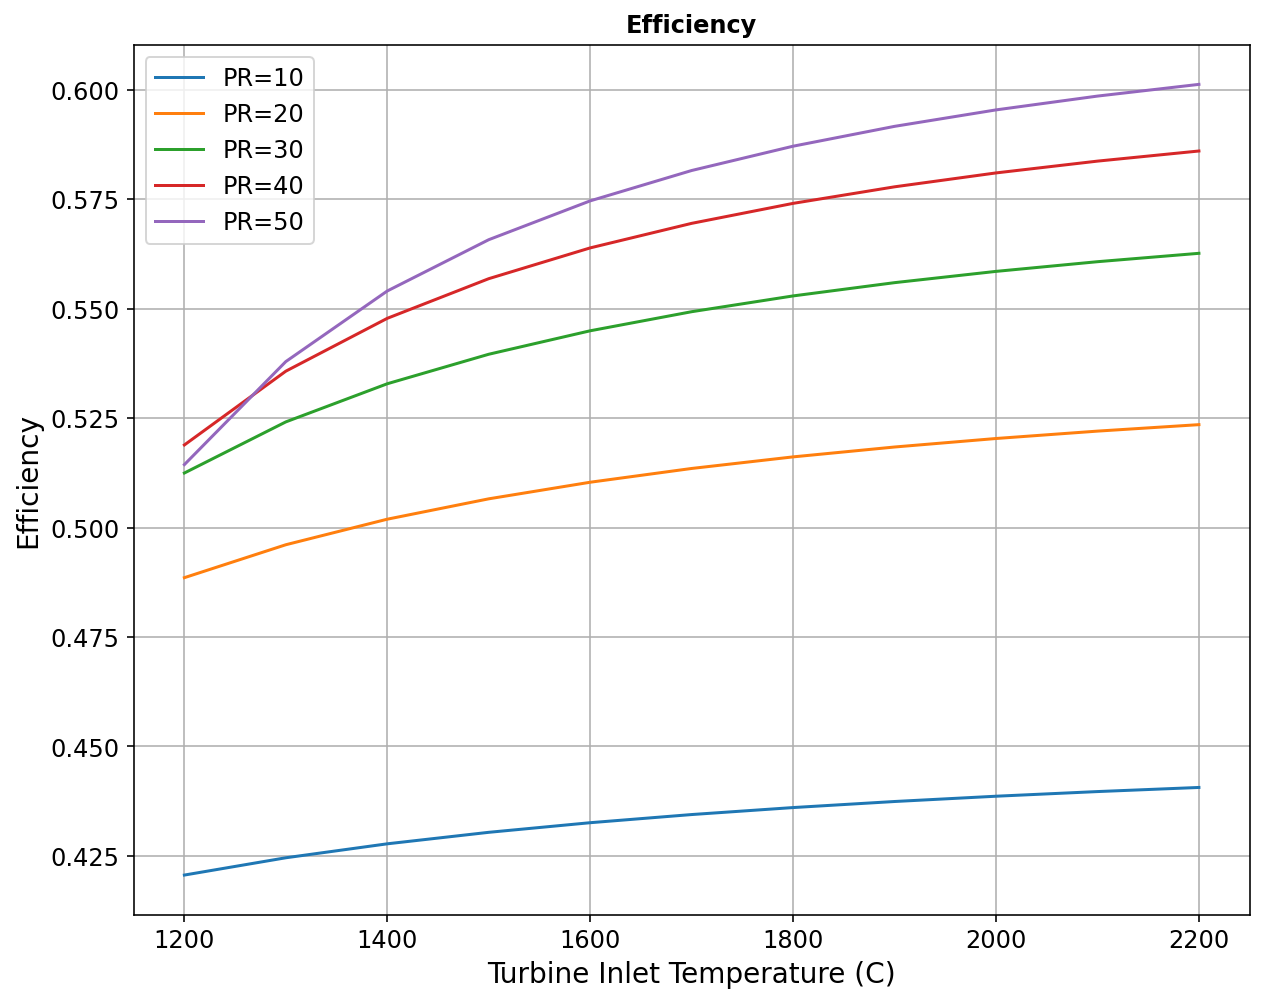

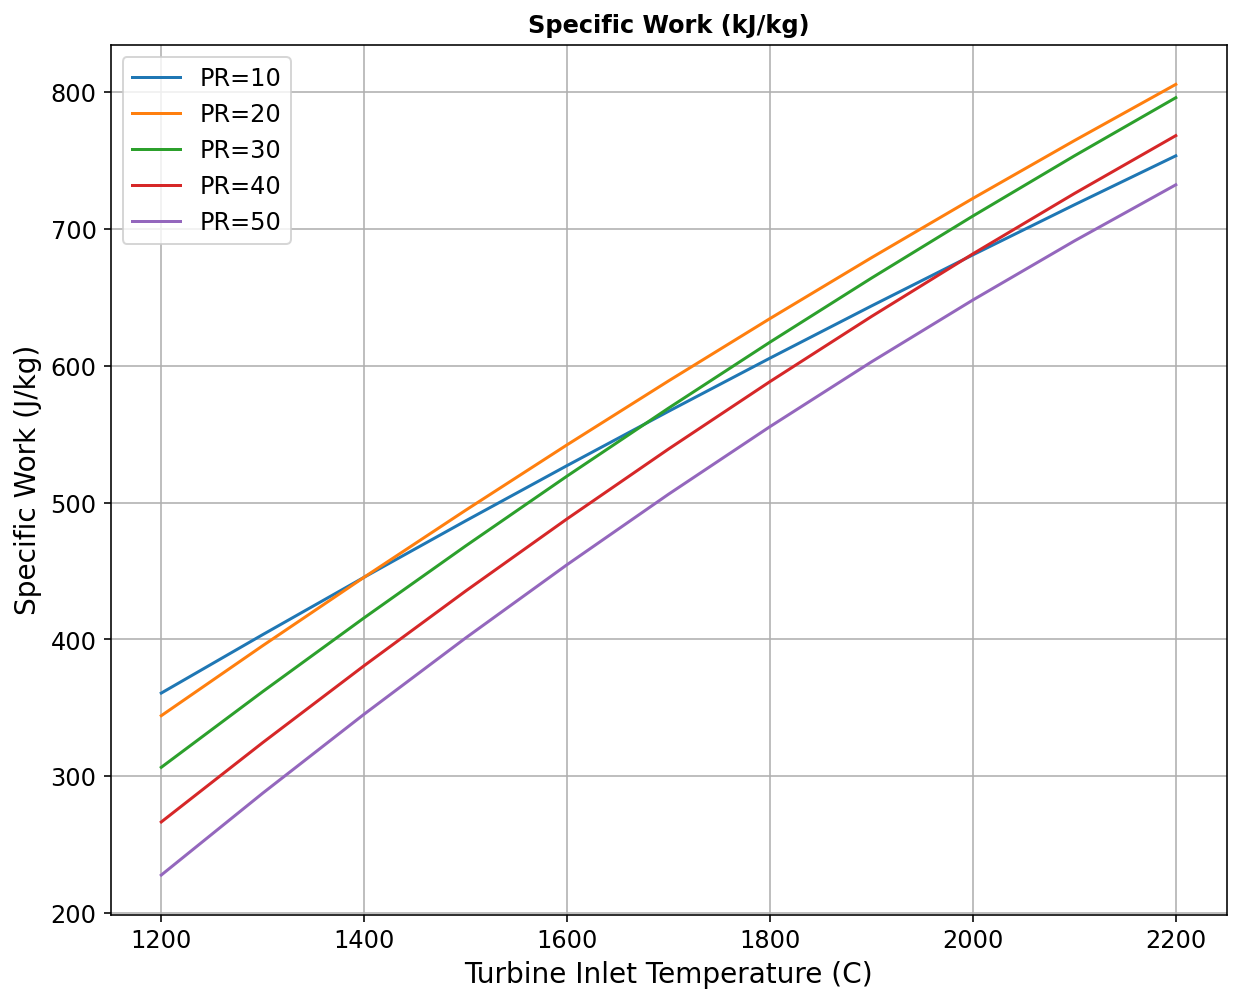

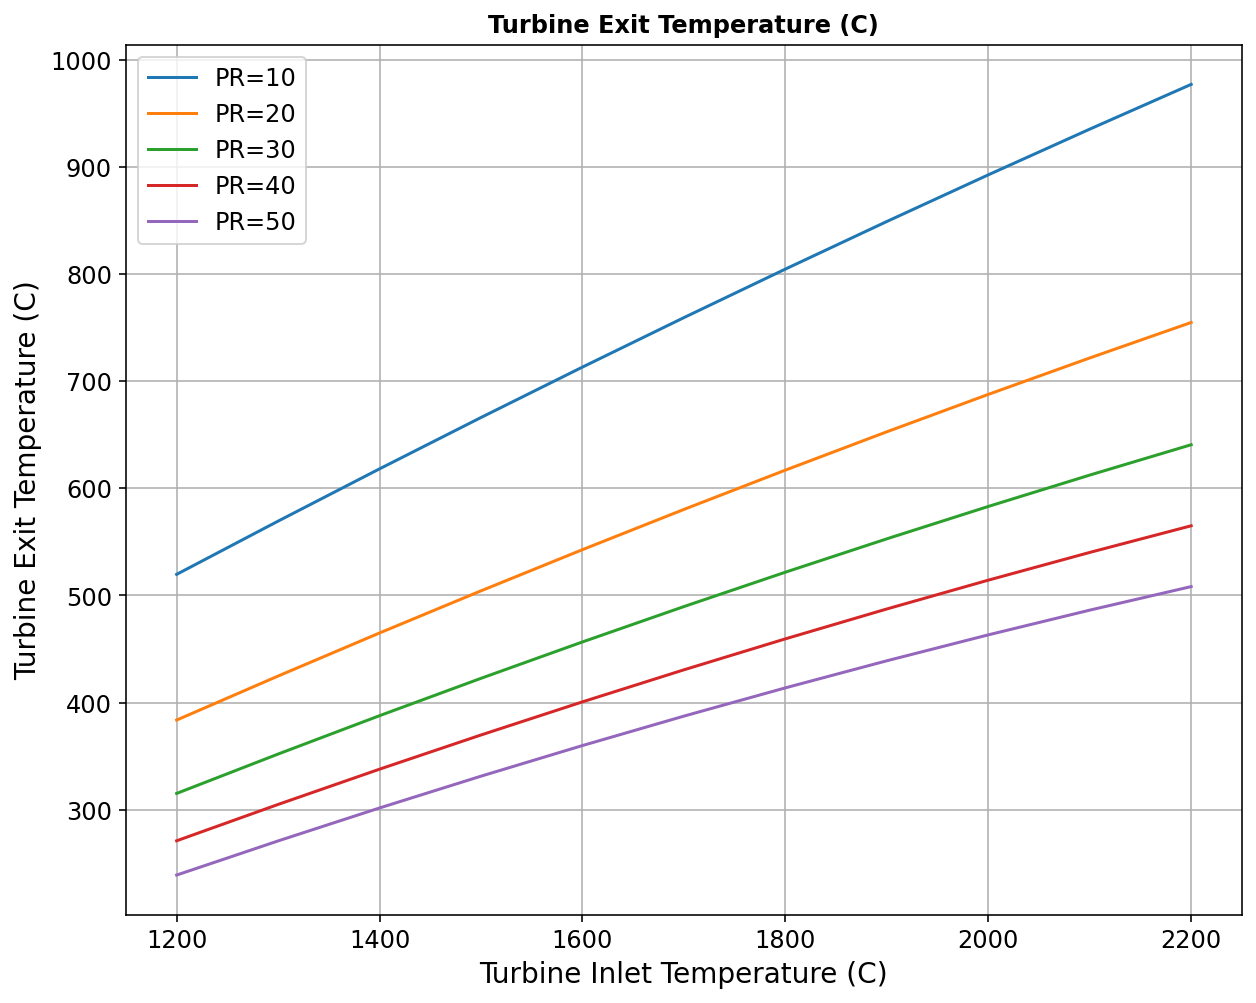

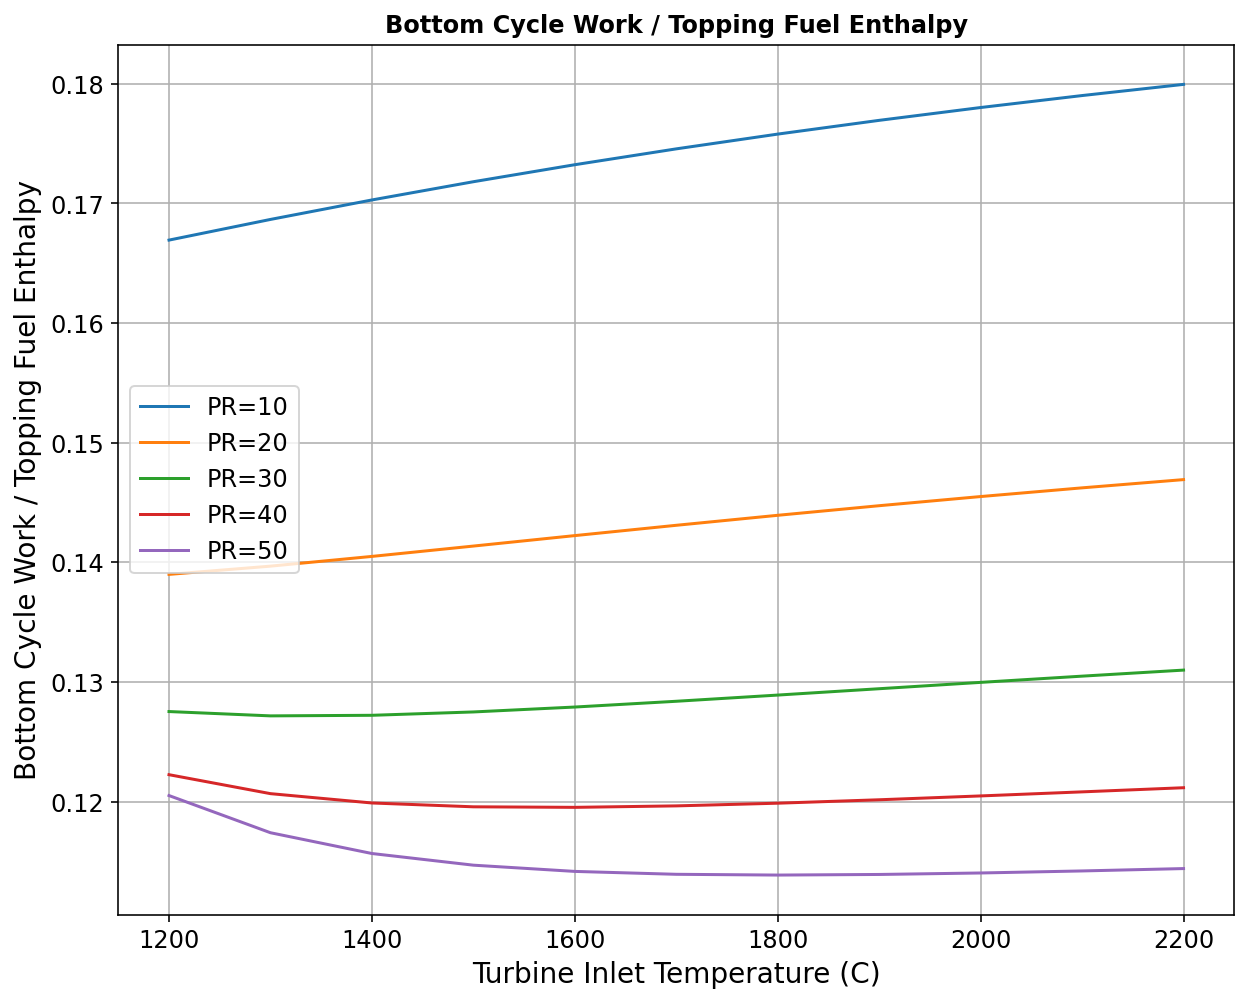

In [ ]:
"""Plot Efficiency vs Turbine Inlet Temperature @ constant pressure ratio"""

# Specific works to consider
PR = [10, 20, 30, 40, 50]

# Turbine inlet temperatures
Turb_Inlet_Temp_C = np.linspace(1200, 2200, 11)

# Ambient static temperature
T_ambient_C=25

# Create empty dataframes for efficiency and mass-specific work
Efficiency = pd.DataFrame(index=Turb_Inlet_Temp_C,
                          columns=[f'PR={pr}' for pr in PR])
Efficiency.index.name = 'TIT (C)'

Work = pd.DataFrame(index=Turb_Inlet_Temp_C,
                          columns=[f'PR={pr}' for pr in PR])
Work.index.name = 'TIT (C)'

# Turbine exit temperature
TET_C = pd.DataFrame(index=Turb_Inlet_Temp_C,
                          columns=[f'PR={pr}' for pr in PR])
TET_C.index.name = 'TIT (C)'

# Bottoming cycle work / Fuel Enthalpy
bottomWork_Fuel = pd.DataFrame(index=Turb_Inlet_Temp_C,
                          columns=[f'PR={pr}' for pr in PR])
bottomWork_Fuel.index.name = 'TIT (C)'

# Carnot efficiency
eta_carnot = lambda T_in_C, T_out_C : 1 - (T_out_C + 273.15) / (T_in_C + 273.15)

# Bottoming cycle efficiency as a % of carnot
eta_bottom_relative = 0.40

for j, pr in enumerate(PR):
  for i,TIT_C in enumerate(Turb_Inlet_Temp_C):

    cycle = SimpleBraytonCycle(ηpoly_compressor=0.9,
                               ηpoly_turbine=0.95,
                               T_ambient_C=T_ambient_C,
                               Turbine_Inlet_Temperature_C=TIT_C, PR=pr)

    Efficiency.iloc[i,j] = cycle.efficiency

    Work.iloc[i,j] = cycle.mass_specific_work/1000

    TET_C.iloc[i,j] = cycle.T_turbine_exit - 273.15

    bottomWork_Fuel.iloc[i,j] = eta_carnot(cycle.T_turbine_exit, T_ambient_C) * eta_bottom_relative * ( 1 - cycle.efficiency)


lineObjects1 = Efficiency.plot(figsize=(10,8), grid=True, title='Efficiency')
lineObjects1.set_xlabel('Turbine Inlet Temperature (C)')
lineObjects1.set_ylabel('Efficiency')

lineObjects2 = Work.plot(figsize=(10,8), grid=True, title='Specific Work (kJ/kg)')
lineObjects2.set_xlabel('Turbine Inlet Temperature (C)')
lineObjects2.set_ylabel('Specific Work (J/kg)')

lineObjects4 = TET_C.plot(figsize=(10,8), grid=True, title='Turbine Exit Temperature (C)')
lineObjects4.set_xlabel('Turbine Inlet Temperature (C)')
lineObjects4.set_ylabel('Turbine Exit Temperature (C)')

lineObjects5 = bottomWork_Fuel.plot(figsize=(10,8), grid=True, title='Bottom Cycle Work / Topping Fuel Enthalpy')
lineObjects5.set_xlabel('Turbine Inlet Temperature (C)')
lineObjects5.set_ylabel('Bottom Cycle Work / Topping Fuel Enthalpy')

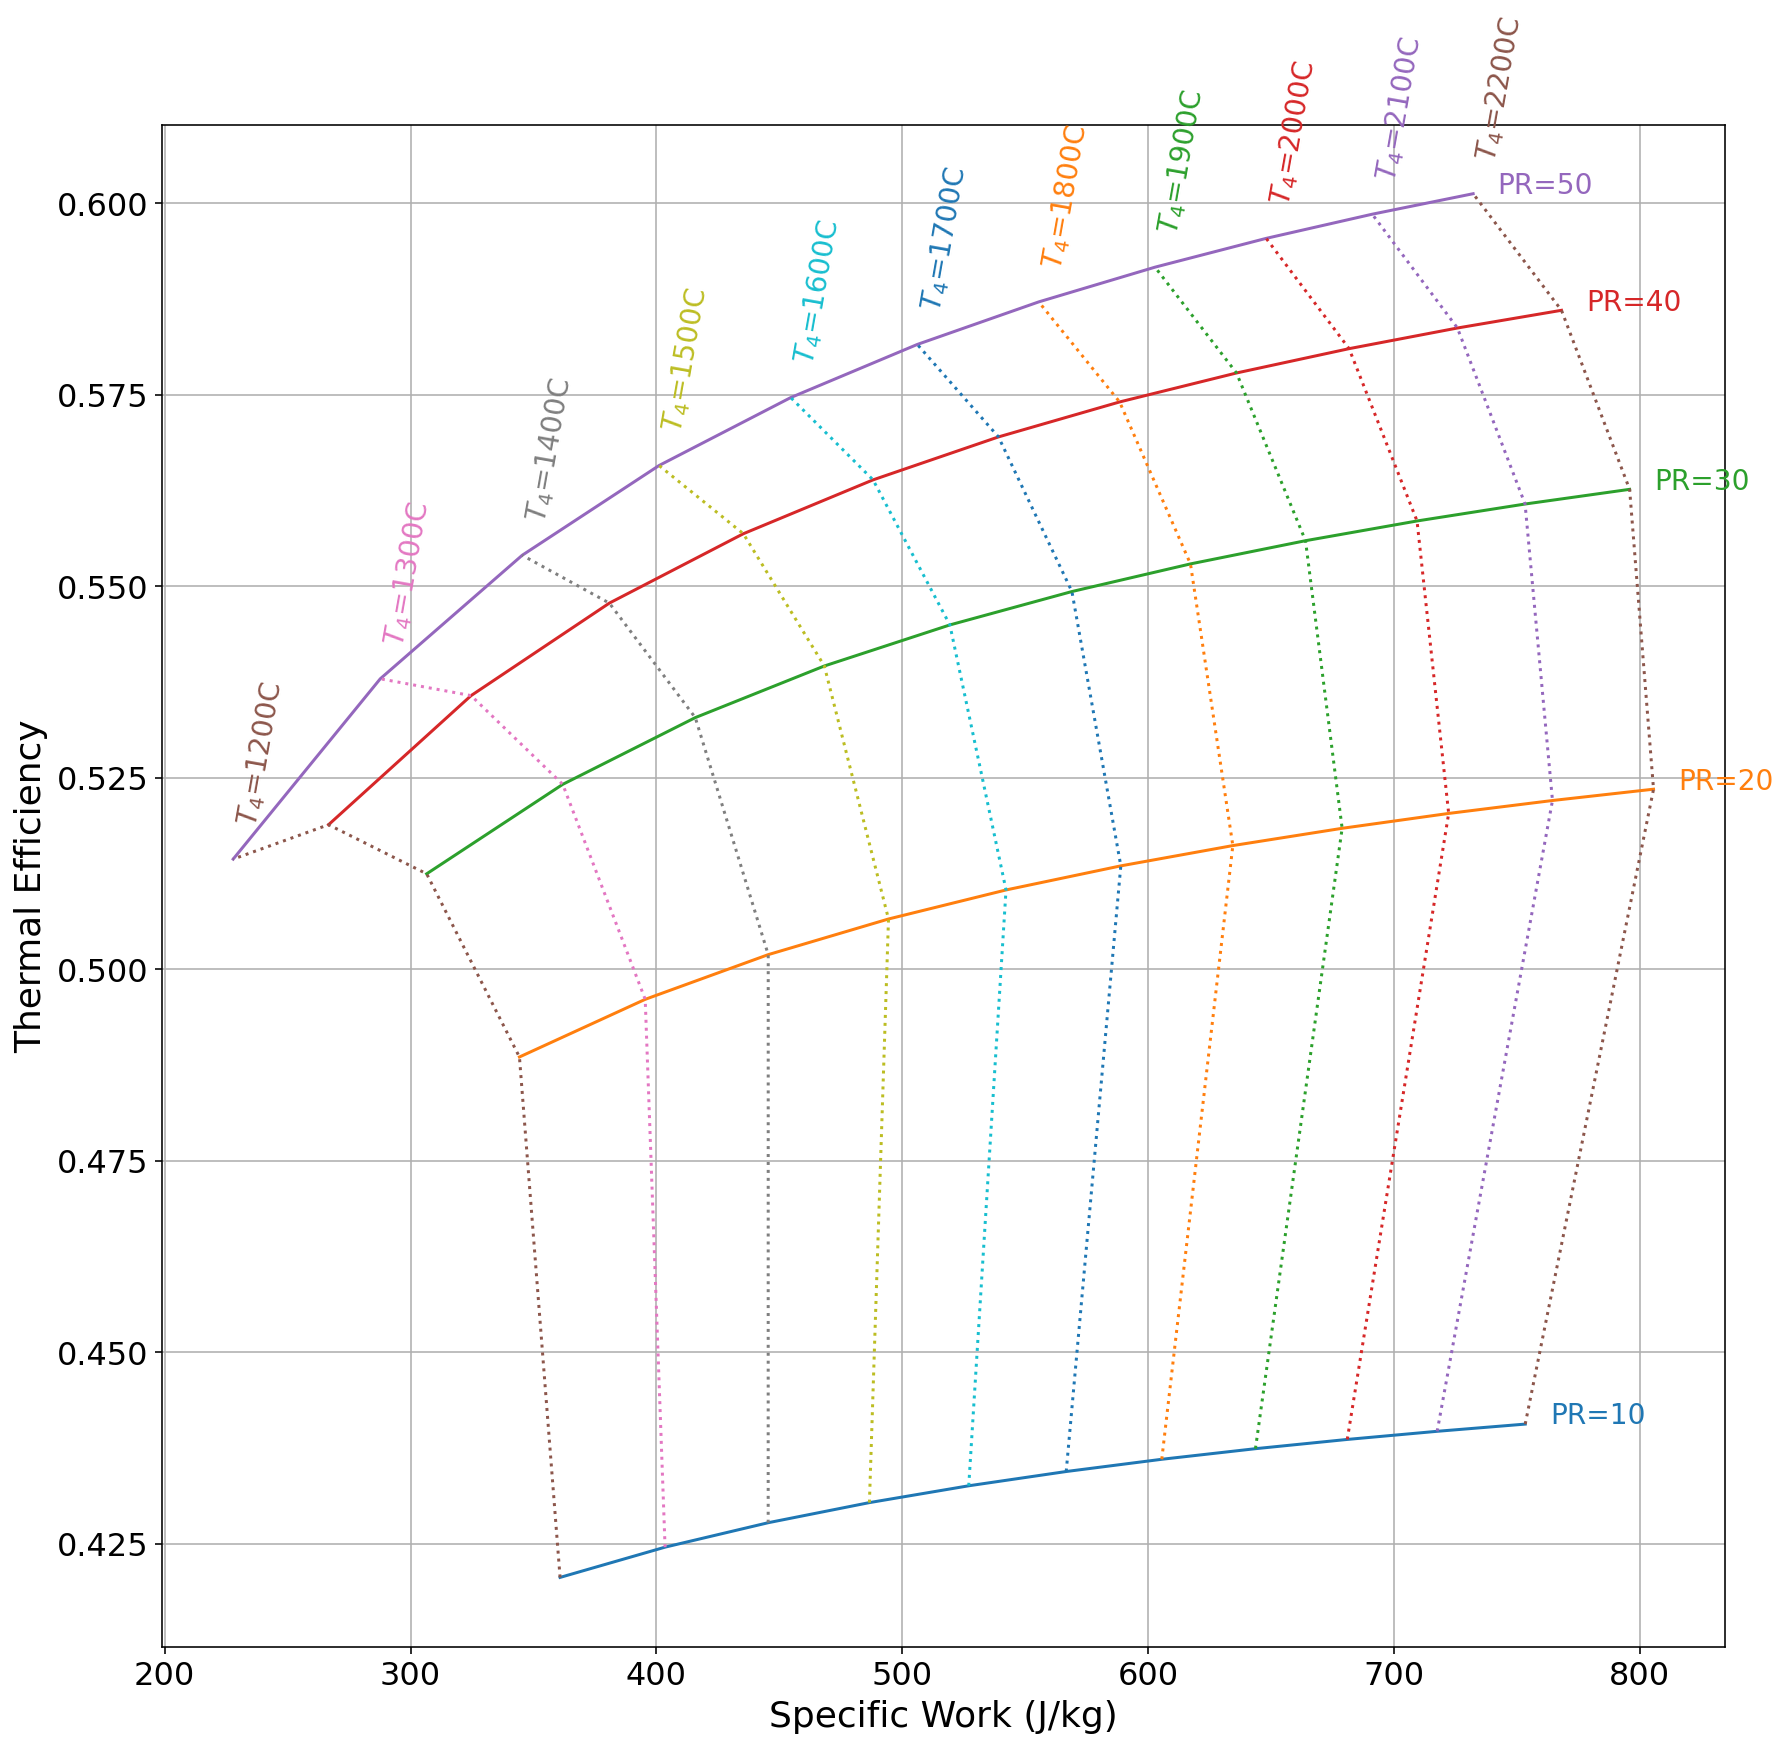

In [ ]:
"""Draw constant TIT & PR lines in space of Efficiency and Specific Work"""
plt.figure(figsize=(14,14))
lineObjects3 = plt.plot(Work,Efficiency)
for line, label in zip(lineObjects3, Work.columns):
  plt.annotate(label, tuple(line._xy[-1]),
               xytext=(line._x[-1]+10, line._y[-1]), color=line._color, fontsize=14)
lineObjects4 = plt.plot(Work.transpose(), Efficiency.transpose(), linestyle=":")
for line, label in zip(lineObjects4, Work.index):
  plt.annotate(f'$T_{4}$={label:.0f}C', line._xy[-1],
               xytext=(line._x[-1],line._y[-1]+0.005),rotation=80, color=line._color, fontsize=14)

plt.grid()
plt.xlabel('Specific Work (J/kg)', fontsize=18)
plt.ylabel('Thermal Efficiency', fontsize=18)

ax = plt.gca()
ax.tick_params(axis='both', labelsize=16)



Text(0, 0.5, 'Efficiency')

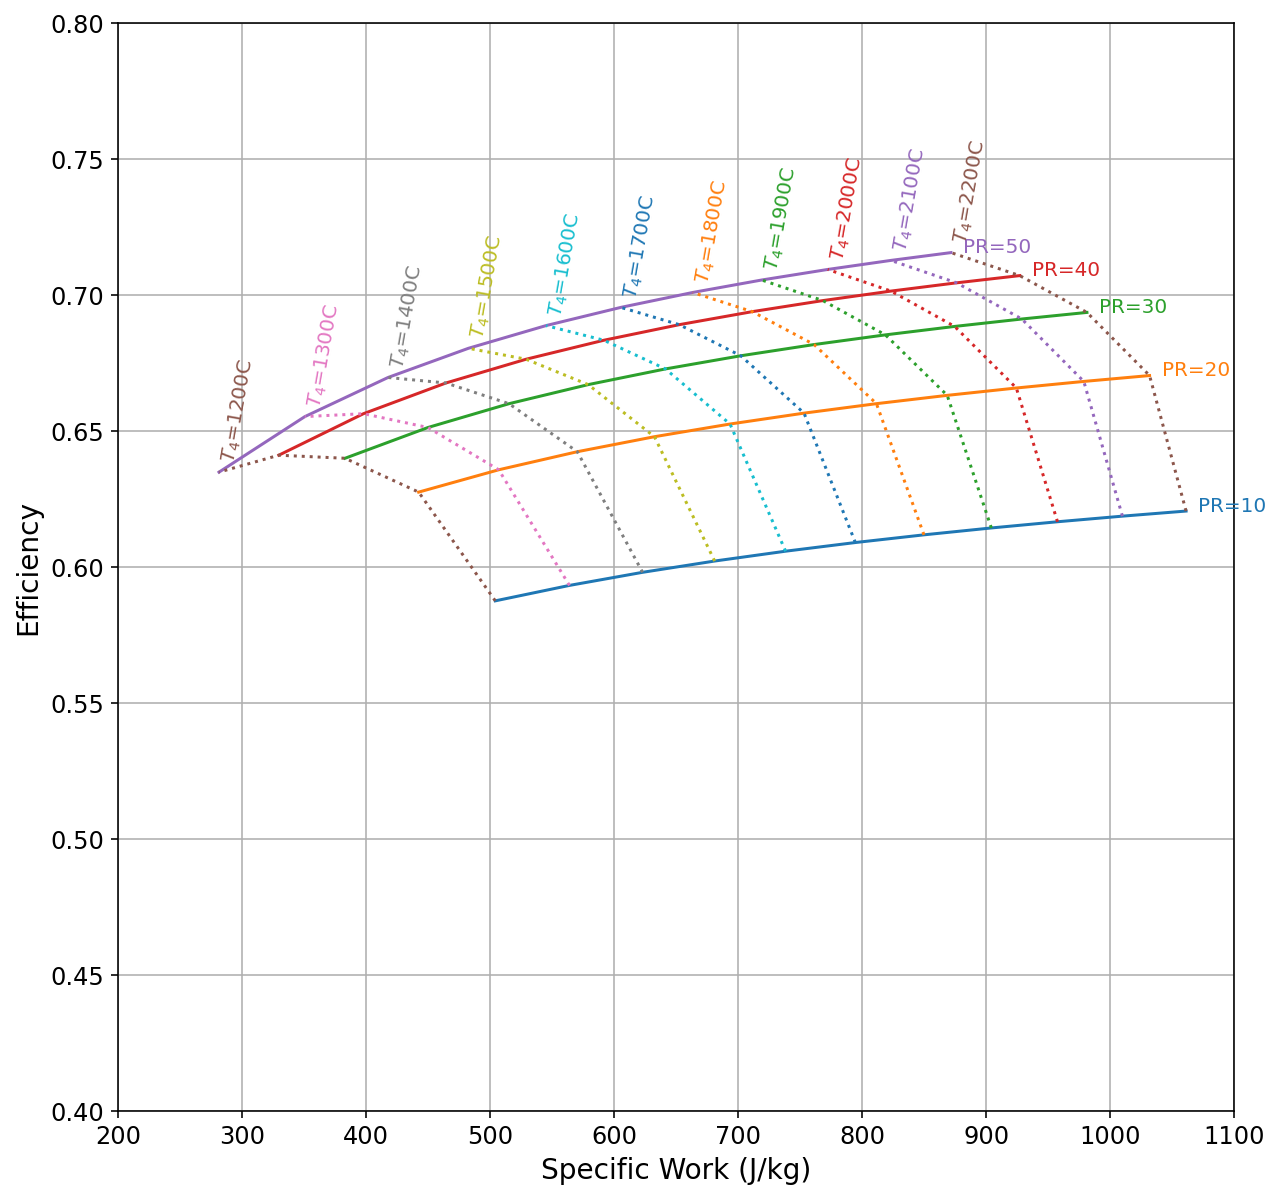

In [ ]:
"""Draw constant TIT & PR lines in space of Efficiency and Specific Work"""
plt.figure(figsize=(10,10))
lineObjects3 = plt.plot(Work*(1+bottomWork_Fuel/Efficiency),Efficiency+bottomWork_Fuel)
for line, label in zip(lineObjects3, Work.columns):
  plt.annotate(label, tuple(line._xy[-1]),
               xytext=(line._x[-1]+10, line._y[-1]), color=line._color)
lineObjects4 = plt.plot((Work*(1+bottomWork_Fuel/Efficiency)).transpose(), (Efficiency+bottomWork_Fuel).transpose(), linestyle=":")
for line, label in zip(lineObjects4, Work.index):
  plt.annotate(f'$T_{4}$={label:.0f}C', line._xy[-1],
               xytext=(line._x[-1],line._y[-1]+0.005),rotation=80, color=line._color)

plt.xlim(200, 1100); plt.ylim(0.4, 0.8)
plt.grid()
plt.xlabel('Specific Work (J/kg)')
plt.ylabel('Efficiency')


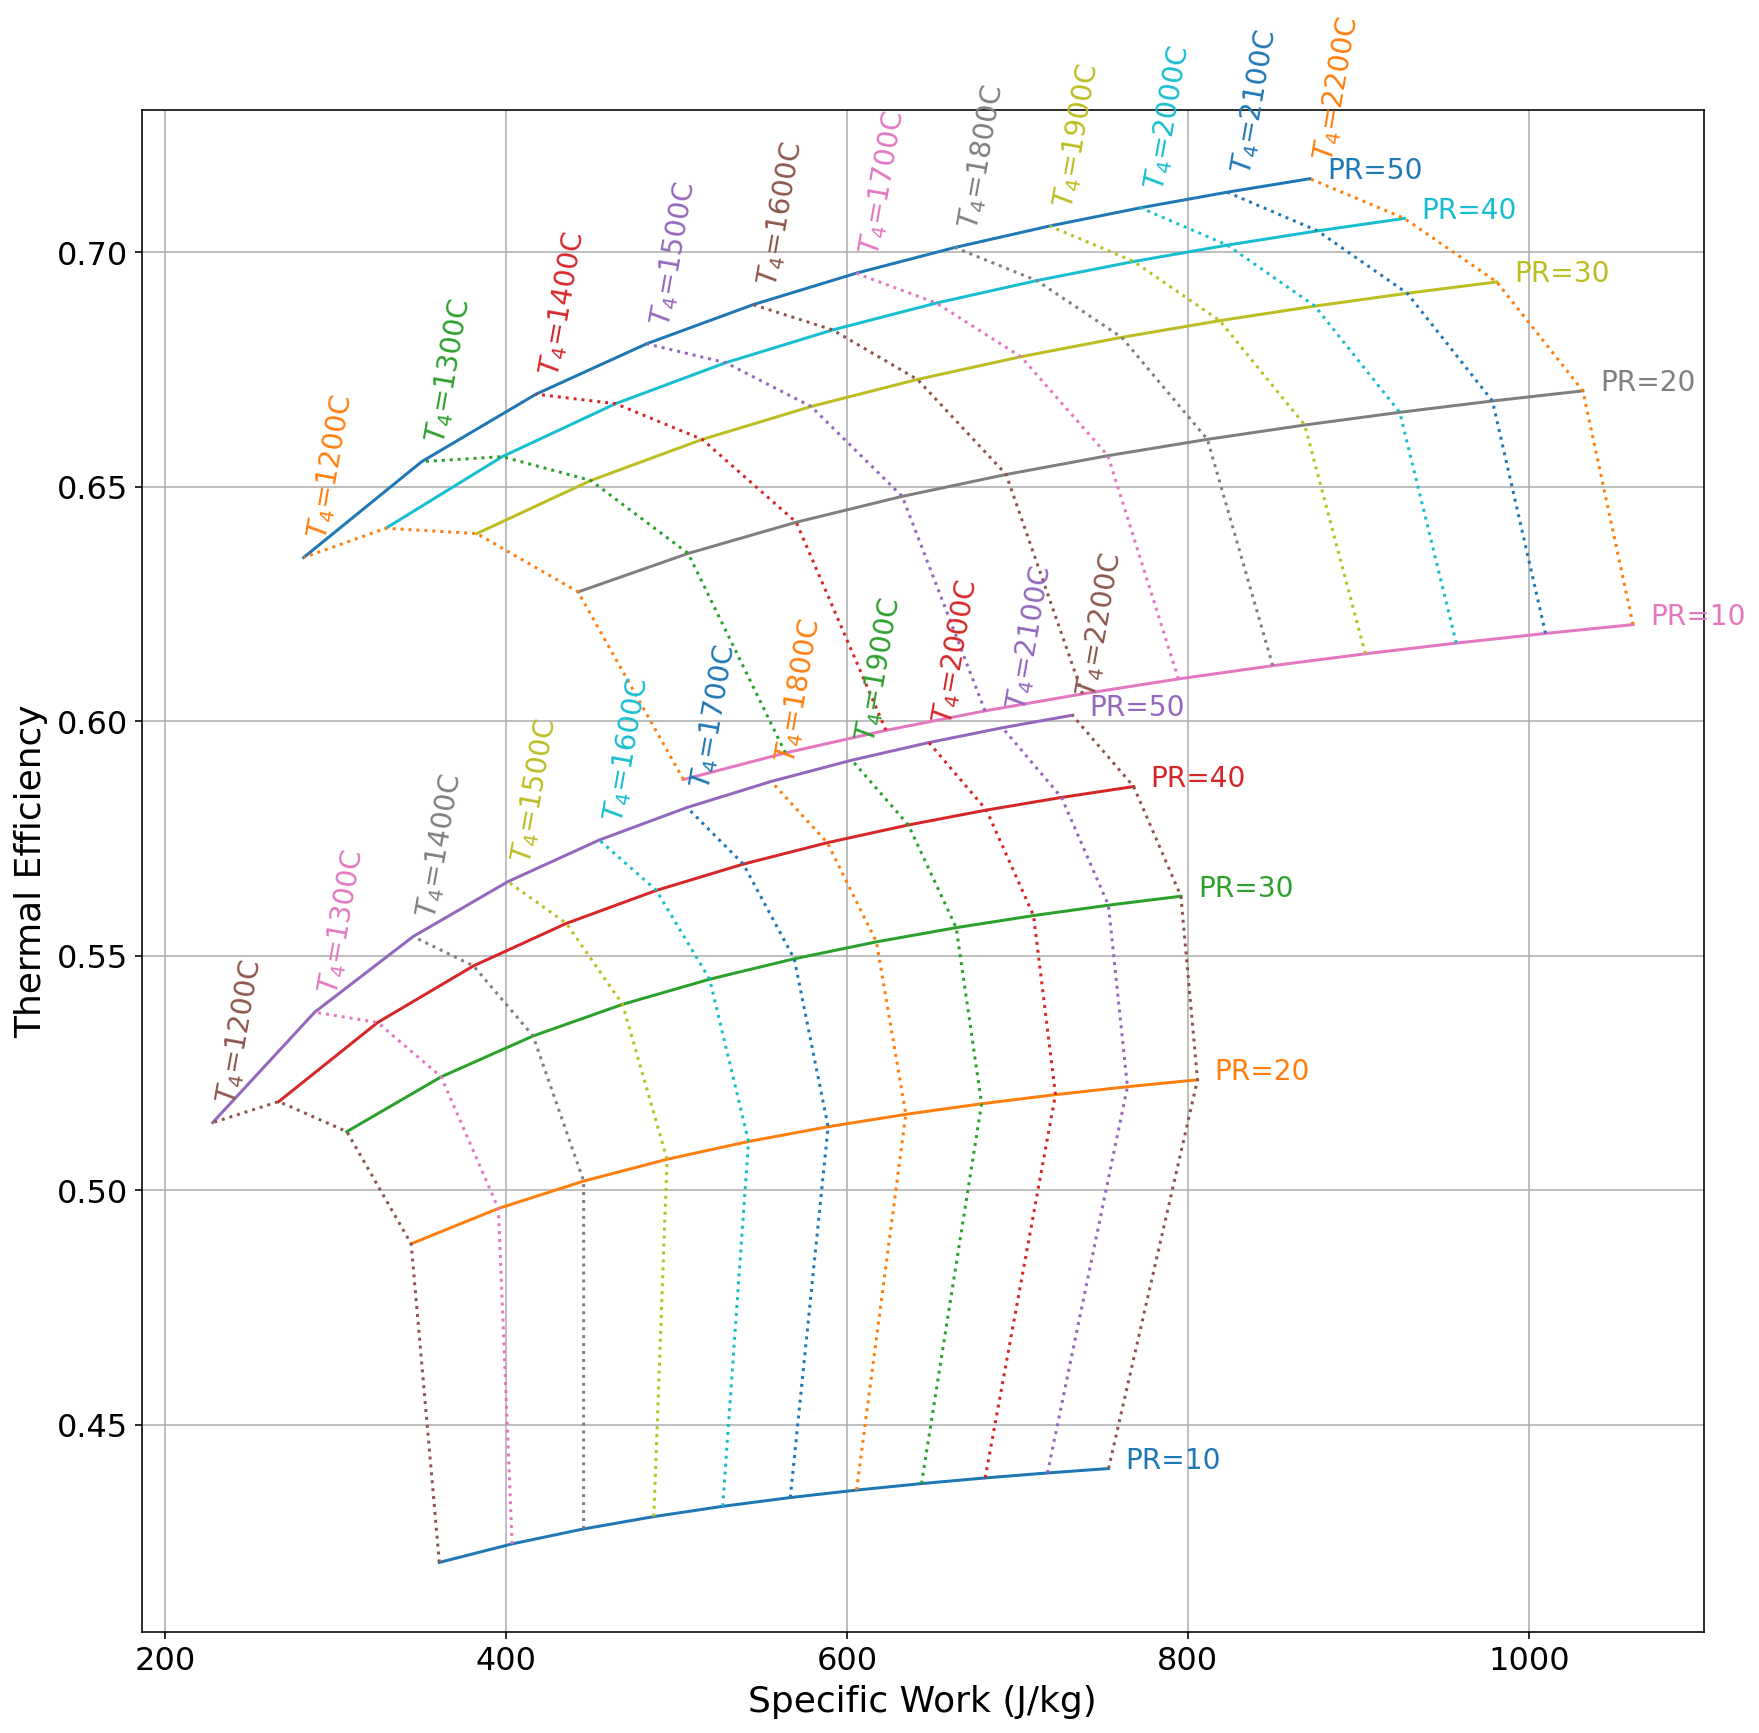

In [ ]:
"""Draw constant TIT & PR lines in space of Efficiency and Specific Work"""
plt.figure(figsize=(14,14))
lineObjects3 = plt.plot(Work,Efficiency)
for line, label in zip(lineObjects3, Work.columns):
  plt.annotate(label, tuple(line._xy[-1]),
               xytext=(line._x[-1]+10, line._y[-1]), color=line._color, fontsize=14)
lineObjects4 = plt.plot(Work.transpose(), Efficiency.transpose(), linestyle=":")
for line, label in zip(lineObjects4, Work.index):
  plt.annotate(f'$T_{4}$={label:.0f}C', line._xy[-1],
               xytext=(line._x[-1],line._y[-1]+0.005),rotation=80, color=line._color, fontsize=14)

lineObjects3 = plt.plot(Work*(1+bottomWork_Fuel/Efficiency),Efficiency+bottomWork_Fuel)
for line, label in zip(lineObjects3, Work.columns):
  plt.annotate(label, tuple(line._xy[-1]),
               xytext=(line._x[-1]+10, line._y[-1]), color=line._color,fontsize=14)
lineObjects4 = plt.plot((Work*(1+bottomWork_Fuel/Efficiency)).transpose(), (Efficiency+bottomWork_Fuel).transpose(), linestyle=":")
for line, label in zip(lineObjects4, Work.index):
  plt.annotate(f'$T_{4}$={label:.0f}C', line._xy[-1],
               xytext=(line._x[-1],line._y[-1]+0.005),rotation=80, color=line._color, fontsize=14)

#plt.xlim(200, 1100); plt.ylim(0.4, 0.8)
plt.grid()
plt.xlabel('Specific Work (J/kg)', fontsize=18)
plt.ylabel('Thermal Efficiency', fontsize=18)

ax = plt.gca()
ax.tick_params(axis='both', labelsize=16)

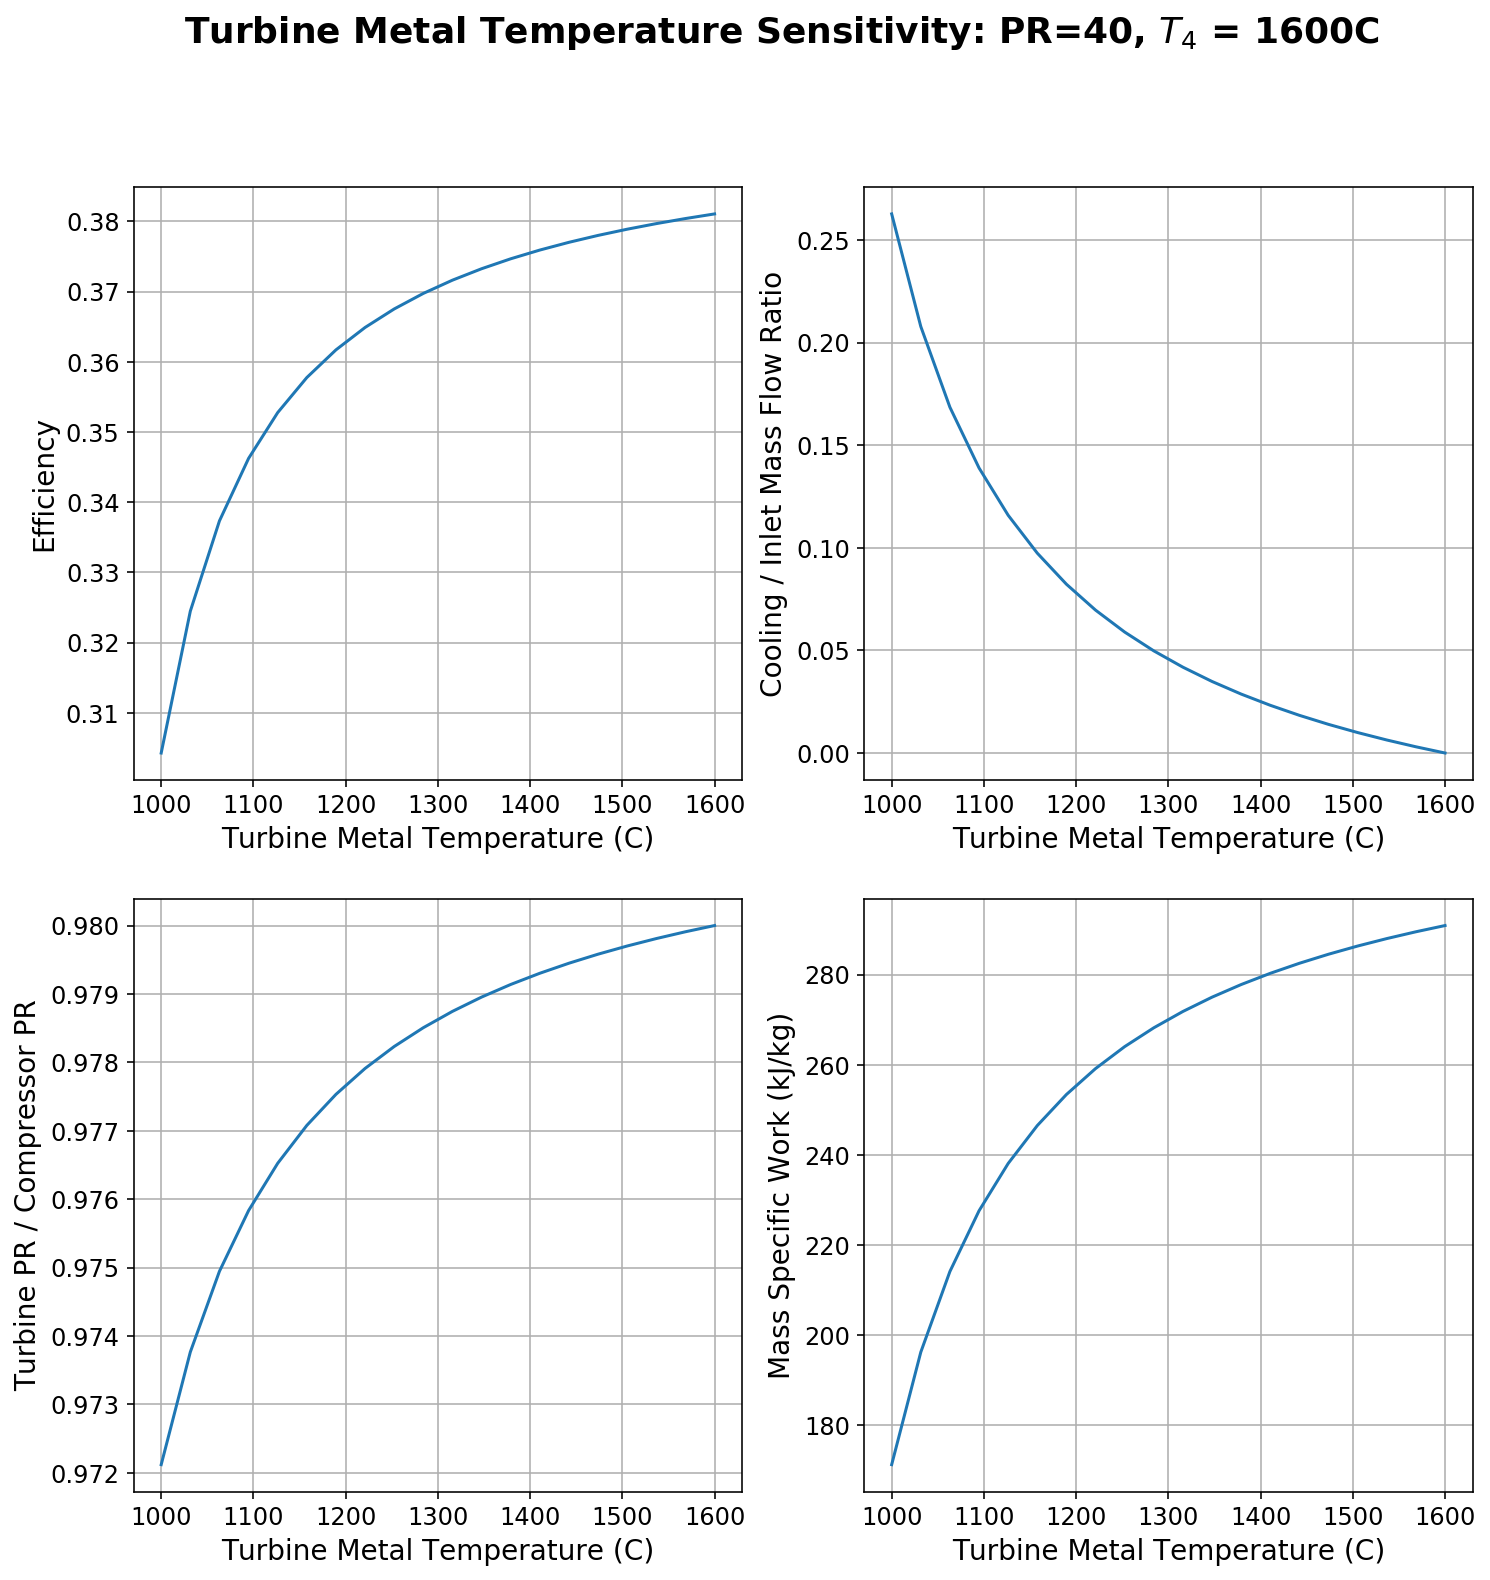

In [ ]:
"""Assess the impact of the cooling flow on efficiency & specific work"""

Turbine_Inlet_Temperature_C = 1600
Turbine_Metal_Temperature_C = np.linspace(1000, 1600, 20)
PR = 40

CoolingStudy = [SimpleBraytonCycle(PR=PR,
                                   Turbine_Inlet_Temperature_C=Turbine_Inlet_Temperature_C,
                                   ηpoly_compressor=0.8,
                                   ηpoly_turbine=0.85,
                                   Turbine_Metal_Temperature_C=TMT_C)
                                  for TMT_C in Turbine_Metal_Temperature_C]

fig, ax = plt.subplots(2,2, figsize=(12,12))
fig.suptitle(f'Turbine Metal Temperature Sensitivity: PR={PR}, $T_{4}$ = {Turbine_Inlet_Temperature_C}C')

ax[0,0].plot(Turbine_Metal_Temperature_C, [case.efficiency for case in CoolingStudy])
ax[0,0].set_xlabel('Turbine Metal Temperature (C)')
ax[0,0].set_ylabel('Efficiency')
ax[0,0].grid();

ax[0,1].plot(Turbine_Metal_Temperature_C, [case.βcooling for case in CoolingStudy])
ax[0,1].set_xlabel('Turbine Metal Temperature (C)')
ax[0,1].set_ylabel('Cooling / Inlet Mass Flow Ratio')
ax[0,1].grid()

ax[1,0].plot(Turbine_Metal_Temperature_C, [case.turbinePR/case.PR for case in CoolingStudy])
ax[1,0].set_xlabel('Turbine Metal Temperature (C)')
ax[1,0].set_ylabel('Turbine PR / Compressor PR')
ax[1,0].grid()

ax[1,1].plot(Turbine_Metal_Temperature_C, [case.mass_specific_work/1000 for case in CoolingStudy])
ax[1,1].set_xlabel('Turbine Metal Temperature (C)')
ax[1,1].set_ylabel('Mass Specific Work (kJ/kg)')
ax[1,1].grid()

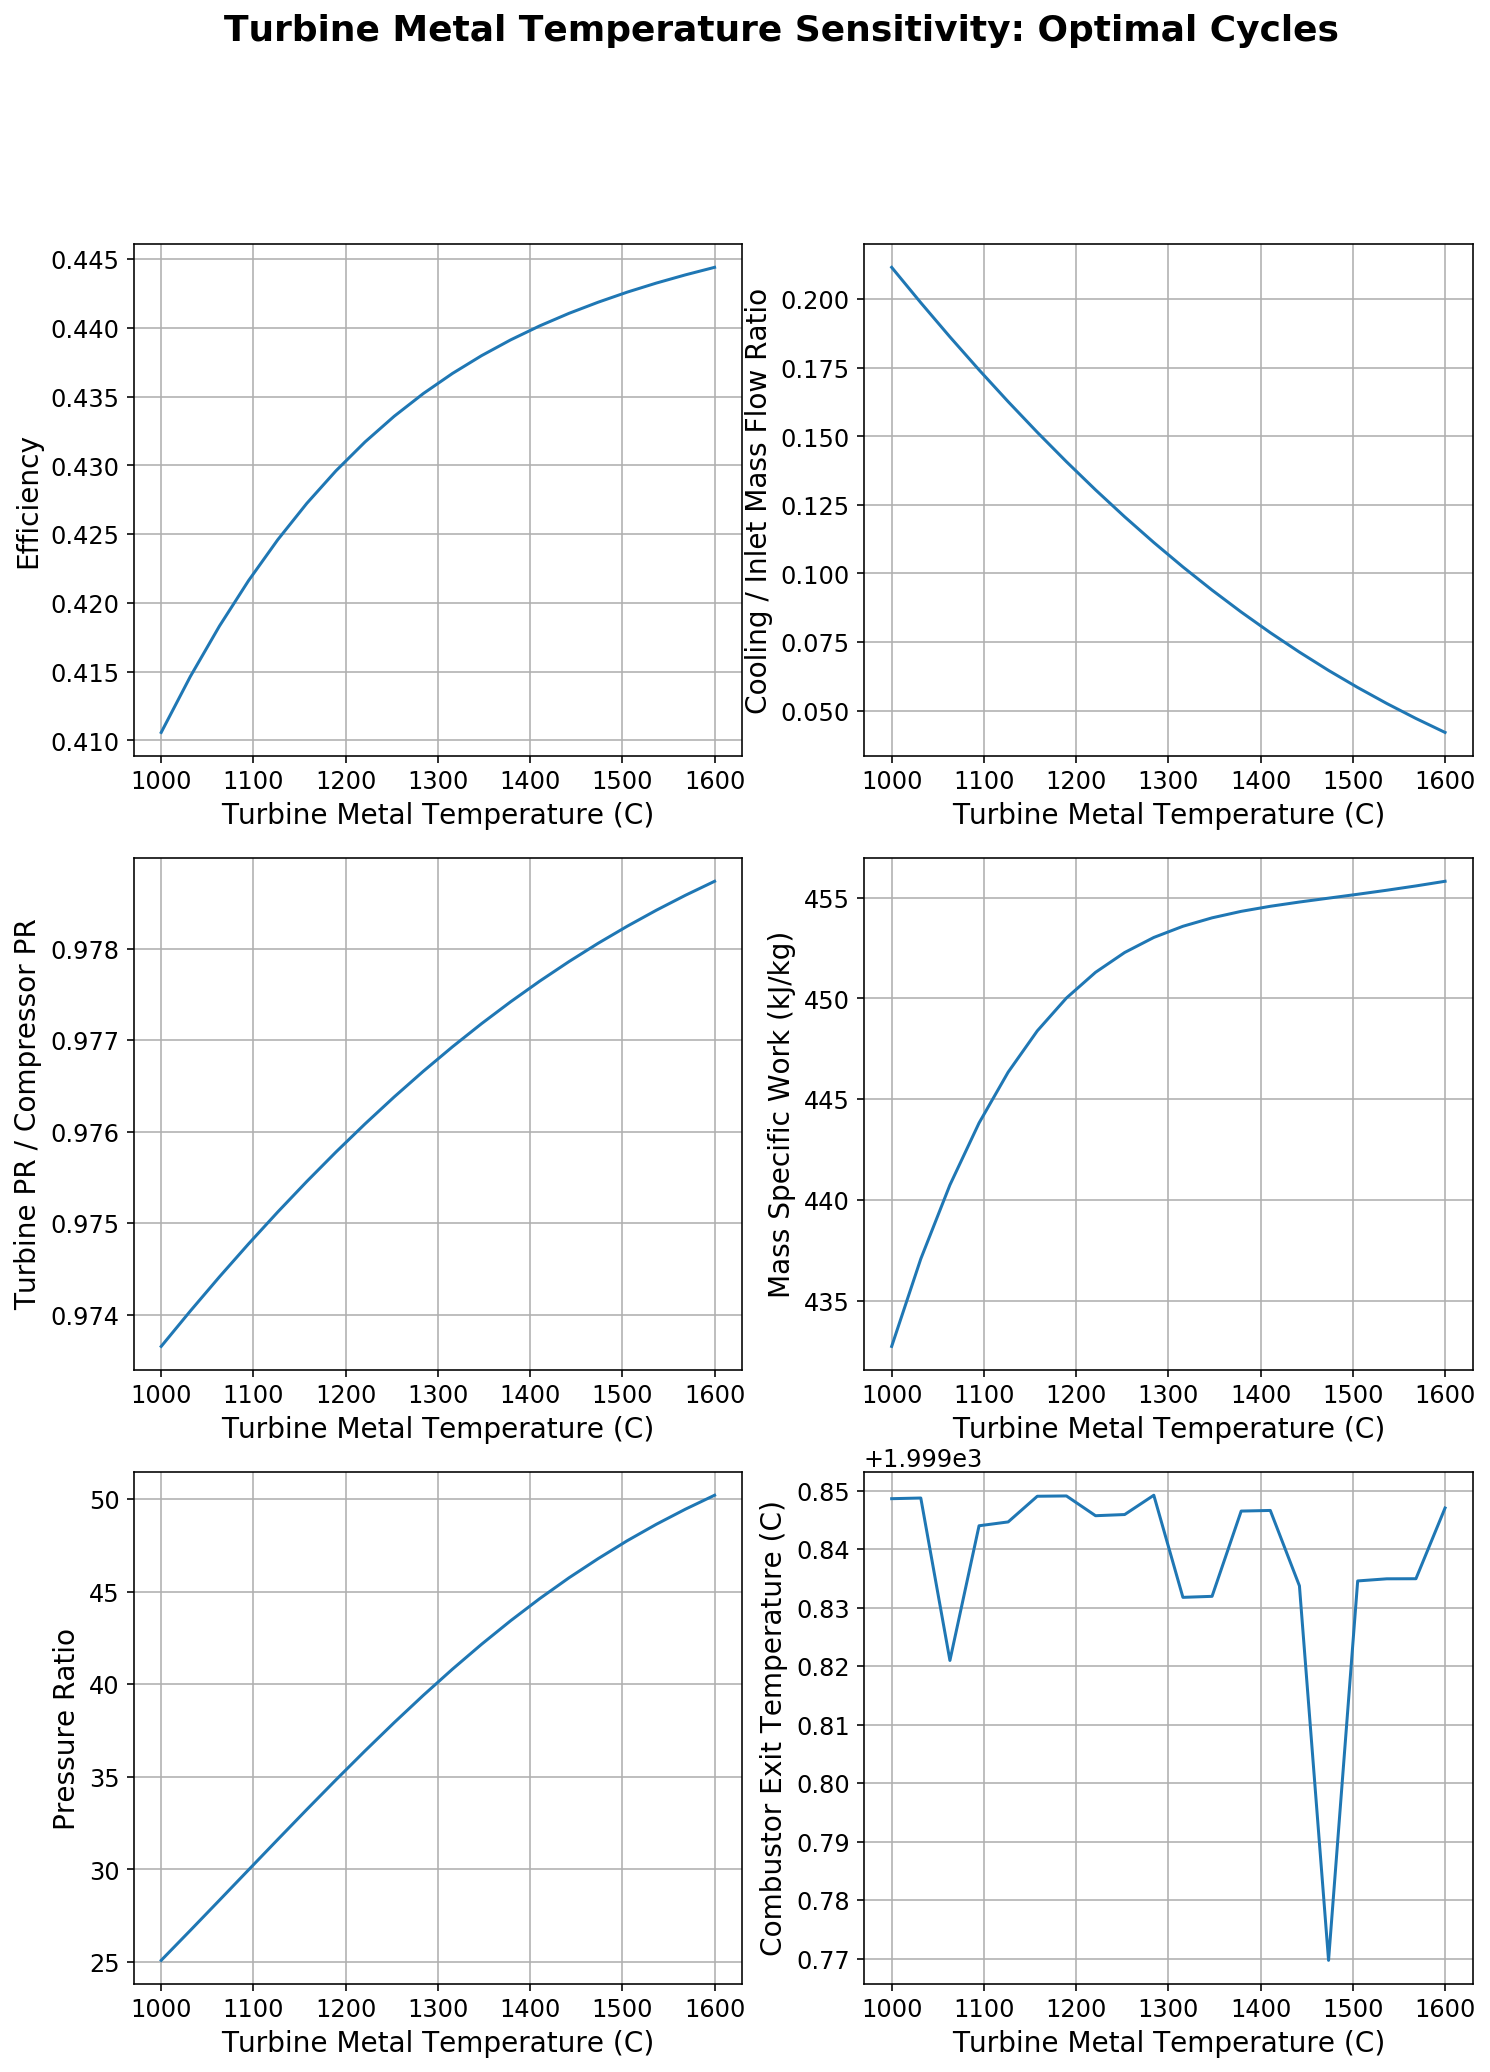

In [ ]:
"""Evaluate performance sensitivity to Turbine Metal using the optimal cycle"""
Turbine_Metal_Temperature_C = np.linspace(1000,1600,20)

optimCycles = [SimpleBraytonCycle(PR=50,
                                  Turbine_Inlet_Temperature_C=1600,
                                  ηpoly_compressor=0.8,
                                  ηpoly_turbine=0.85,
                                  burnerPR=0.98,
                                  coolingPR=0.95,
                                  Turbine_Metal_Temperature_C=TMT_C).optimize()
                                  for TMT_C in Turbine_Metal_Temperature_C]

fig, ax = plt.subplots(3,2, figsize=(12,16))
fig.suptitle(f'Turbine Metal Temperature Sensitivity: Optimal Cycles')

ax[0,0].plot(Turbine_Metal_Temperature_C, [case.efficiency for case in optimCycles])
ax[0,0].set_xlabel('Turbine Metal Temperature (C)')
ax[0,0].set_ylabel('Efficiency')
ax[0,0].grid();

ax[0,1].plot(Turbine_Metal_Temperature_C, [case.βcooling for case in optimCycles])
ax[0,1].set_xlabel('Turbine Metal Temperature (C)')
ax[0,1].set_ylabel('Cooling / Inlet Mass Flow Ratio')
ax[0,1].grid()

ax[1,0].plot(Turbine_Metal_Temperature_C, [case.turbinePR/case.PR for case in optimCycles])
ax[1,0].set_xlabel('Turbine Metal Temperature (C)')
ax[1,0].set_ylabel('Turbine PR / Compressor PR')
ax[1,0].grid()

ax[1,1].plot(Turbine_Metal_Temperature_C, [case.mass_specific_work/1000 for case in optimCycles])
ax[1,1].set_xlabel('Turbine Metal Temperature (C)')
ax[1,1].set_ylabel('Mass Specific Work (kJ/kg)')
ax[1,1].grid()

ax[2,0].plot(Turbine_Metal_Temperature_C, [case.PR for case in optimCycles])
ax[2,0].set_xlabel('Turbine Metal Temperature (C)')
ax[2,0].set_ylabel('Pressure Ratio')
ax[2,0].grid()

ax[2,1].plot(Turbine_Metal_Temperature_C, [case.T_combustor_exit-273.15 for case in optimCycles])
ax[2,1].set_xlabel('Turbine Metal Temperature (C)')
ax[2,1].set_ylabel('Combustor Exit Temperature (C)')
ax[2,1].grid()